# <center>Applied Data Science Capstone</center>

#### <center>In completion of requirements for the IBM Data Science Professional Certificate on Coursera</center>

<hr>

This file will be used to implement a capstone data science project using location data from Foursquare.

Watch it grow on [GitHub](https://github.com/Arkadiatri/Coursera_Capstone/)!

In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup # had to install to environment in Anaconda
import lxml # had to install to environment in Anaconda, backdated to 4.6.1 (4.6.2 current) for pandas read_html()
import html5lib # had to install to environment in Anaconda (1.1 current) for pandas read_html()

In [2]:
print('Hello Capstone Project Course!')

Hello Capstone Project Course!


## Table of Toronto postal codes

First we will use the Requests module to get the [webpage]('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M') containing the data we need.

In [3]:
import requests

In [4]:
url_wikipedia_postal_codes = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

In [5]:
webpage = requests.get(url_wikipedia_postal_codes)

We could inspect webpage.text and extract the tables with BeautifulSoup, but parsing tables from the webpage text is actually handled by Pandas.

Let's inspect the tables automatically parsed from the page:

In [6]:
df = pd.read_html(webpage.text)
for i, d in enumerate(df):
    print(f'Table {i}:')
    display(d.head())

Table 0:


,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


Table 1:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,NaN,Canadian postal codes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NL NS PE NB QC ON MB SK AB BC NU/NT YT A B C E...,NL NS PE NB QC ON MB SK AB BC NU/NT YT A B C E...,NL NS PE NB QC ON MB SK AB BC NU/NT YT A B C E...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NL,NS,PE,NB,QC,QC,QC,ON,ON,ON,ON,ON,MB,SK,AB,BC,NU/NT,YT
3,A,B,C,E,G,H,J,K,L,M,N,P,R,S,T,V,X,Y


Table 2:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,NL,NS,PE,NB,QC,QC,QC,ON,ON,ON,ON,ON,MB,SK,AB,BC,NU/NT,YT
1,A,B,C,E,G,H,J,K,L,M,N,P,R,S,T,V,X,Y


By inspection, the table we want is at index 0.

In [7]:
df = df[0].astype(str)
df.shape

(180, 3)

Let's clean up the columns.

First, the Postal Code is expected to be unique:

In [8]:
len(df['Postal Code'].unique()) == len(df['Postal Code'])

True

So rows are uniquely indexed by the Postal Code, as desired, and we do not have to combine neighborhoods into a comma separated list as per the assignment instructions - they already are.

Second, we take only the Borough that are not 'Not Assigned':

In [9]:
df = df[df['Borough']!='Not assigned'].reset_index(drop=True)
display(df.head())
df.shape

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


(103, 3)

So 77 Postal Codes were not assigned to a Borough.

We should also ensure that all Borough names are legitimate.  This must be done manually.

In [10]:
df['Borough'].unique()

array(['North York', 'Downtown Toronto', 'Etobicoke', 'Scarborough',
       'East York', 'York', 'East Toronto', 'West Toronto',
       'Central Toronto', 'Mississauga'], dtype=object)

Those all look like Borough names, and there are 10 total.

Third, we want each entry in Neighborhood that is 'Not assigned' to be the Borough name.

In [11]:
def showalldf(df):
    old_opt = pd.get_option('display.max_rows')
    numel = len(df.index)
    pd.set_option('display.max_rows', len(df.index))
    display(df)
    pd.set_option('display.max_rows', old_opt)

In [294]:
print(f"There are {df[df['Neighbourhood']=='Not assigned'].size} Neighborhoods not assigned")
print('Neighborhoods are:')
showalldf(df['Neighbourhood'])

There are 0 Neighborhoods not assigned
Neighborhoods are:


0                                              Parkwoods
1                                       Victoria Village
2                              Regent Park, Harbourfront
3                       Lawrence Manor, Lawrence Heights
4            Queen's Park, Ontario Provincial Government
5                Islington Avenue, Humber Valley Village
6                                         Malvern, Rouge
7                                              Don Mills
8                        Parkview Hill, Woodbine Gardens
9                               Garden District, Ryerson
10                                             Glencairn
11     West Deane Park, Princess Gardens, Martin Grov...
12                Rouge Hill, Port Union, Highland Creek
13                                             Don Mills
14                                      Woodbine Heights
15                                        St. James Town
16                                    Humewood-Cedarvale
17     Eringate, Bloordale Gard

So all Neighbourhood entries look non-empty.

But on closer inspection there are entries that don't make sense for a neighborhood analysis, so we should drop them:
* Row 76: Canada Post Gateway Processing Centre
* Row 92: Stn A PO Boxes
* Row 100: Business reply mail Processing Centre, South Central Letter Processing Plant Toronto

These will actually be removed in a later step where we eliminate postal codes that have no residential space associated with them (like govenment buildings, office buildings, commercial plazas).  We will keep the full dataframe for now.  The drop on inspection was previously (and incompletely) performed with the line:

    df_cleaned = df.drop(index=[76, 92, 100]).reset_index(drop=True)

We conclude this section by displaying the final dataframe:

In [295]:
showalldf(df)

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
6,M1B,Scarborough,"Malvern, Rouge"
7,M3B,North York,Don Mills
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


And finally, the postal codes dataframe shape is:

In [296]:
df.shape

(103, 3)

## Latitude and Longitude for each Toronto Postal Code

After looking through many geopy and geocoder options, I chose to use Nominatim.  While Nominatim doesn't succeed for partial postal code lookup, it did succeed with many neighborhoods.  Sevearal missed assignments were due to using slightly different names, but there were still over 80 imperfectly assigned neighborhood locations.

I then tried using a commercial service.  Google appears to charge for any developer use, but HERE has a freemium service which I did sign up for.  With an API key I was able to get geopy to geocode a partial postal code, so I'll be continuing work there.  Note that the geocoder module does not seem to work, possibly due to a misconfigured web address for requests (based on the errors returned).

To keep api keys secret, they are stored in a config.py file listed in the .gitignore file on GitHub.

To reload the configuration file should it need to be changed in development, run:

    import importlib
    importlib.reload(config)

For HERE, we need supply just the REST API key (on their site, called the app code)

In [299]:
import config

In [300]:
from geopy.geocoders import Here
gc = Here(apikey=config.HERE_APIKEY)

Now we can try to geocode the postal codes

In [360]:
df_c = df.copy(deep=True)
for i, row in df_c.iterrows():
    g = gc.geocode(f"{row['Postal Code']}, Ontario")
    if g!=None:
        df_c.loc[i,'GString'] = g[0]
        df_c.loc[i,'Latitude'] = g[1][0]
        df_c.loc[i,'Longitude'] = g[1][1]
    else:
        print(f"Geocoding failed for Postal Code: {row['Postal Code']}, Borough: {row['Borough']}, Neighborhoods: {row['Neighbourhood']}")

Geocoding failed for Postal Code: M7R, Borough: Mississauga, Neighborhoods: Canada Post Gateway Processing Centre
Geocoding failed for Postal Code: M5W, Borough: Downtown Toronto, Neighborhoods: Stn A PO Boxes
Geocoding failed for Postal Code: M7Y, Borough: East Toronto, Neighborhoods: Business reply mail Processing Centre, South Central Letter Processing Plant Toronto


Offline inspection for missing values:

In [361]:
print(f"There are {df_c[df_c['GString']==None].shape[0]} rows where geocoding failed")
df_tmp = df_c['GString'].copy()
for i, val in enumerate(df_tmp):
    if pd.isnull(val):
        df_tmp[i] = -1
    else:
        df_tmp[i] = val.find(df_c.loc[i,'Postal Code'])
print(f"There are {sum(df_tmp==-1)} rows where the postal code is not found in the geocoded Location")
if sum(df_tmp==-1)>0:
    print(f"The geocoding failed at indices {df_tmp[df_tmp==-1].index.to_list()}, entries shown below:")
    display(df_c.loc[df_tmp==-1,:])

There are 0 rows where geocoding failed
There are 3 rows where the postal code is not found in the geocoded Location
The geocoding failed at indices [76, 92, 100], entries shown below:


,Postal Code,Borough,Neighbourhood,GString,Latitude,Longitude
76,M7R,Mississauga,Canada Post Gateway Processing Centre,NaN,NaN,NaN
92,M5W,Downtown Toronto,Stn A PO Boxes,NaN,NaN,NaN
100,M7Y,East Toronto,"Business reply mail Processing Centre, South C...",NaN,NaN,NaN


Wow, that was so much easier than trying to massage the Nominatim data (see Appendix).

Note that these three indices are the ones we previously considered for removal by manual inspection of the neighborhood list.  We can remove them here.

In [363]:
df_c.drop(index=df_tmp[df_tmp==-1].index.to_list(), inplace=True)
df_c.reset_index(drop=True, inplace=True)
df_c.shape

(100, 6)

Let's load up the csv file of locations and see if it matches.

In [365]:
df_gt = pd.read_csv('Geospatial_Coordinates.csv')
df_gt.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [366]:
df_gt.shape

(103, 3)

In [367]:
df_gt.rename(columns={'Latitude':'GT Latitude','Longitude':'GT Longitude'}, inplace=True)
df_gt.head()

,Postal Code,GT Latitude,GT Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [368]:
df_d = df_c.merge(df_gt, on='Postal Code')
df_d

,Postal Code,Borough,Neighbourhood,GString,Latitude,Longitude,GT Latitude,GT Longitude
0,M3A,North York,Parkwoods,"M3A, Toronto, ON, Canada, Toronto, ON M3A, CAN",43.75245,-79.32991,43.753259,-79.329656
1,M4A,North York,Victoria Village,"M4A, Toronto, ON, Canada, Toronto, ON M4A, CAN",43.73057,-79.31306,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront","M5A, Toronto, ON, Canada, Toronto, ON M5A, CAN",43.65512,-79.36264,43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights","M6A, Toronto, ON, Canada, Toronto, ON M6A, CAN",43.72327,-79.45042,43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government","M7A, Toronto, ON, Canada, Toronto, ON M7A, CAN",43.66253,-79.39188,43.662301,-79.389494
...,...,...,...,...,...,...,...,...
95,M5X,Downtown Toronto,"First Canadian Place, Underground city","M5X, Toronto, ON, Canada, Toronto, ON M5X, CAN",43.64828,-79.38146,43.648429,-79.382280
96,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North","M8X, Toronto, ON, Canada, Toronto, ON M8X, CAN",43.65319,-79.51113,43.653654,-79.506944
97,M4Y,Downtown Toronto,Church and Wellesley,"M4Y, Toronto, ON, Canada, Toronto, ON M4Y, CAN",43.66659,-79.38133,43.665860,-79.383160
98,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...","M8Y, Toronto, ON, Canada, Toronto, ON M8Y, CAN",43.63278,-79.48945,43.636258,-79.498509


In [369]:
df_d['Diff Lat'] = df_d['Latitude']-df_d['GT Latitude']
df_d['Diff Lon'] = df_d['Longitude']-df_d['GT Longitude']
df_d.head()

,Postal Code,Borough,Neighbourhood,GString,Latitude,Longitude,GT Latitude,GT Longitude,Diff Lat,Diff Lon
0,M3A,North York,Parkwoods,"M3A, Toronto, ON, Canada, Toronto, ON M3A, CAN",43.75245,-79.32991,43.753259,-79.329656,-0.000809,-0.000253
1,M4A,North York,Victoria Village,"M4A, Toronto, ON, Canada, Toronto, ON M4A, CAN",43.73057,-79.31306,43.725882,-79.315572,0.004688,0.002512
2,M5A,Downtown Toronto,"Regent Park, Harbourfront","M5A, Toronto, ON, Canada, Toronto, ON M5A, CAN",43.65512,-79.36264,43.654260,-79.360636,0.000860,-0.002004
3,M6A,North York,"Lawrence Manor, Lawrence Heights","M6A, Toronto, ON, Canada, Toronto, ON M6A, CAN",43.72327,-79.45042,43.718518,-79.464763,0.004752,0.014343
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government","M7A, Toronto, ON, Canada, Toronto, ON M7A, CAN",43.66253,-79.39188,43.662301,-79.389494,0.000228,-0.002386


In [370]:
print(f"Latitude difference:  {df_d['Diff Lat'].abs().mean():0.5f} +/- {df_d['Diff Lat'].abs().std():0.5f} with maximum {df_d['Diff Lat'].abs().max():0.5f}")
print(f"Longitude difference: {df_d['Diff Lon'].abs().mean():0.5f} +/- {df_d['Diff Lon'].abs().std():0.5f} with maximum {df_d['Diff Lon'].abs().max():0.5f}")

Latitude difference:  0.00253 +/- 0.00261 with maximum 0.01830
Longitude difference: 0.00352 +/- 0.00330 with maximum 0.01464


What do these differences mean in terms of distance?

In [371]:
from geopy import distance
for i, row in df_d.iterrows():
    df_d.loc[i,'GT Diff Meters'] = distance.distance((row['Latitude'],row['Longitude']),(row['GT Latitude'],row['GT Longitude'])).meters
print(f"Differences: {df_d['GT Diff Meters'].mean():0.1f} +/- {df_d['GT Diff Meters'].std():0.1f} meters with maximum {df_d['GT Diff Meters'].max():0.1f} meters and minimum {df_d['GT Diff Meters'].min():0.1f} meters")
df_d.head()

Differences: 438.4 +/- 348.7 meters with maximum 2189.5 meters and minimum 5.4 meters


,Postal Code,Borough,Neighbourhood,GString,Latitude,Longitude,GT Latitude,GT Longitude,Diff Lat,Diff Lon,GT Diff Meters
0,M3A,North York,Parkwoods,"M3A, Toronto, ON, Canada, Toronto, ON M3A, CAN",43.75245,-79.32991,43.753259,-79.329656,-0.000809,-0.000253,92.132080
1,M4A,North York,Victoria Village,"M4A, Toronto, ON, Canada, Toronto, ON M4A, CAN",43.73057,-79.31306,43.725882,-79.315572,0.004688,0.002512,558.767359
2,M5A,Downtown Toronto,"Regent Park, Harbourfront","M5A, Toronto, ON, Canada, Toronto, ON M5A, CAN",43.65512,-79.36264,43.654260,-79.360636,0.000860,-0.002004,187.801580
3,M6A,North York,"Lawrence Manor, Lawrence Heights","M6A, Toronto, ON, Canada, Toronto, ON M6A, CAN",43.72327,-79.45042,43.718518,-79.464763,0.004752,0.014343,1270.683919
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government","M7A, Toronto, ON, Canada, Toronto, ON M7A, CAN",43.66253,-79.39188,43.662301,-79.389494,0.000228,-0.002386,194.136996


That's a very big difference!  Though most are smaller, we'd still like some confidence in knowing which to use.

Manually inspecting Google Maps, the outline for M6A postal code has the HERE Lat/Long at the center, and the csv value near the left edge of the zone.  For M8Y, both HERE and csv are a little off, though HERE is probably closer.  Ideally with the postal code polygons we could find the center of mass, but that level of exactness won't help us.

Let's look at the distribution of nearest-neighbor distances, since this might inform our choice of neighborhood radius.

In [372]:
dist_matrix = []
for i, row in df_d.iterrows():
    # This implementation is slow by a factor of 2, look into distance matrix functions
    dist_matrix.append([distance.distance((row['Latitude'],row['Longitude']),(x['Latitude'],x['Longitude'])).meters for j, x in df_d.iterrows()])
    df_d.loc[i,'NN Distance'] = min([x for x in dist_matrix[-1] if x > 0])
    df_d.loc[i,'NN Index'] = np.argmin(np.array([(9999999 if x==0 else x) for x in dist_matrix[-1]]))
dist_nn = [min([x for x in y if x > 0]) for y in dist_matrix]
df_d['NN Index'] = df_d['NN Index'].astype(int)
df_d.head()

,Postal Code,Borough,Neighbourhood,GString,Latitude,Longitude,GT Latitude,GT Longitude,Diff Lat,Diff Lon,GT Diff Meters,NN Distance,NN Index
0,M3A,North York,Parkwoods,"M3A, Toronto, ON, Canada, Toronto, ON M3A, CAN",43.75245,-79.32991,43.753259,-79.329656,-0.000809,-0.000253,92.132080,2372.990767,71
1,M4A,North York,Victoria Village,"M4A, Toronto, ON, Canada, Toronto, ON M4A, CAN",43.73057,-79.31306,43.725882,-79.315572,0.004688,0.002512,558.767359,2458.529673,71
2,M5A,Downtown Toronto,"Regent Park, Harbourfront","M5A, Toronto, ON, Canada, Toronto, ON M5A, CAN",43.65512,-79.36264,43.654260,-79.360636,0.000860,-0.002004,187.801580,1117.129701,15
3,M6A,North York,"Lawrence Manor, Lawrence Heights","M6A, Toronto, ON, Canada, Toronto, ON M6A, CAN",43.72327,-79.45042,43.718518,-79.464763,0.004752,0.014343,1270.683919,1831.552727,10
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government","M7A, Toronto, ON, Canada, Toronto, ON M7A, CAN",43.66253,-79.39188,43.662301,-79.389494,0.000228,-0.002386,194.136996,802.728256,79


Text(0.5, 1.0, 'Toronto Postal Code Nearest-Neighbor Distances')

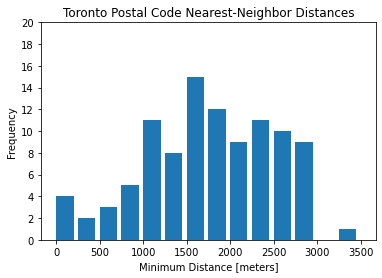

In [373]:
import matplotlib.pyplot as plt
%matplotlib inline

ax = df_d['NN Distance'].plot(kind='hist', bins=np.arange(0,3750,250), width=200)
plt.yticks(np.arange(0,22,2));
plt.xlabel('Minimum Distance [meters]')
plt.title('Toronto Postal Code Nearest-Neighbor Distances')

Large separations make sense for some of the larger neighborhoods, but is there something up for the short distances?

Let's inspect all postal codes with separation less than raidus meters:

In [374]:
radius = 500
showalldf(df_d[df_d['NN Distance']<radius])

,Postal Code,Borough,Neighbourhood,GString,Latitude,Longitude,GT Latitude,GT Longitude,Diff Lat,Diff Lon,GT Diff Meters,NN Distance,NN Index
15,M5C,Downtown Toronto,St. James Town,"M5C, Toronto, ON, Canada, Toronto, ON M5C, CAN",43.65215,-79.37587,43.651494,-79.375418,0.000656,-0.000452,81.511463,493.141949,48
30,M5H,Downtown Toronto,"Richmond, Adelaide, King","M5H, Toronto, ON, Canada, Toronto, ON M5H, CAN",43.64970,-79.38258,43.650571,-79.384568,-0.000871,0.001987,187.294775,181.813045,95
36,M5J,Downtown Toronto,"Harbourfront East, Union Station, Toronto Islands","M5J, Toronto, ON, Canada, Toronto, ON M5J, CAN",43.64285,-79.38076,43.640816,-79.381752,0.002034,0.000992,239.783683,476.266913,42
42,M5K,Downtown Toronto,"Toronto Dominion Centre, Design Exchange","M5K, Toronto, ON, Canada, Toronto, ON M5K, CAN",43.64710,-79.38153,43.647177,-79.381576,-0.000077,0.000046,9.317962,131.225914,95
48,M5L,Downtown Toronto,"Commerce Court, Victoria Hotel","M5L, Toronto, ON, Canada, Toronto, ON M5L, CAN",43.64840,-79.37914,43.648198,-79.379817,0.000202,0.000677,59.022021,187.648145,95
95,M5X,Downtown Toronto,"First Canadian Place, Underground city","M5X, Toronto, ON, Canada, Toronto, ON M5X, CAN",43.64828,-79.38146,43.648429,-79.382280,-0.000149,0.000820,68.217170,131.225914,42


As could be expected, Downtown Toronto is the densest area of the city.  First Canadian Place and Underground city are an office building and an extensive network of underground tunnels and shops - a hiccup for Euclidian analysis.  What happens if we drop that neighborhood?

In [375]:
ind_remove = 95
dist_matrix = [[e for j, e in enumerate(d) if j!=ind_remove] for i, d in enumerate(dist_matrix) if i!=ind_remove]
dist_nn = [min([x for x in y if x > 0]) for y in dist_matrix]
dist_nn_index = [np.argmin(np.array([(9999999 if x==0 else x) for x in d])) for d in dist_matrix]

In [376]:
df_e = df_d.copy()
df_e.drop(index=95, inplace=True)
df_e.reset_index(drop=True, inplace=True)
df_e['NN Distance'] = dist_nn
df_e['NN Index'] = dist_nn_index
df_e.tail()

,Postal Code,Borough,Neighbourhood,GString,Latitude,Longitude,GT Latitude,GT Longitude,Diff Lat,Diff Lon,GT Diff Meters,NN Distance,NN Index
94,M4X,Downtown Toronto,"St. James Town, Cabbagetown","M4X, Toronto, ON, Canada, Toronto, ON M4X, CAN",43.66788,-79.36649,43.667967,-79.367675,-0.000087,0.001185,96.084488,1205.443164,96
95,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North","M8X, Toronto, ON, Canada, Toronto, ON M8X, CAN",43.65319,-79.51113,43.653654,-79.506944,-0.000464,-0.004186,341.628963,1737.986298,5
96,M4Y,Downtown Toronto,Church and Wellesley,"M4Y, Toronto, ON, Canada, Toronto, ON M4Y, CAN",43.66659,-79.38133,43.665860,-79.383160,0.000730,0.001830,168.412786,963.099157,4
97,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...","M8Y, Toronto, ON, Canada, Toronto, ON M8Y, CAN",43.63278,-79.48945,43.636258,-79.498509,-0.003478,0.009059,826.883270,2203.391077,80
98,M8Z,Etobicoke,"Mimico NW, The Queensway West, South of Bloor,...","M8Z, Toronto, ON, Canada, Toronto, ON M8Z, CAN",43.62513,-79.52681,43.628841,-79.520999,-0.003711,-0.005811,624.420805,2824.982434,91


Text(0.5, 1.0, 'Toronto Postal Code Nearest-Neighbor Distances')

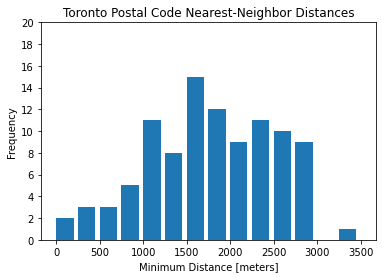

In [377]:
ax = df_e['NN Distance'].plot(kind='hist', bins=np.arange(0,3750,250), width=200)
plt.yticks(np.arange(0,22,2));
plt.xlabel('Minimum Distance [meters]')
plt.title('Toronto Postal Code Nearest-Neighbor Distances')

In [378]:
radius = 500
showalldf(df_e[df_e['NN Distance']<radius])

,Postal Code,Borough,Neighbourhood,GString,Latitude,Longitude,GT Latitude,GT Longitude,Diff Lat,Diff Lon,GT Diff Meters,NN Distance,NN Index
15,M5C,Downtown Toronto,St. James Town,"M5C, Toronto, ON, Canada, Toronto, ON M5C, CAN",43.65215,-79.37587,43.651494,-79.375418,0.000656,-0.000452,81.511463,493.141949,48
30,M5H,Downtown Toronto,"Richmond, Adelaide, King","M5H, Toronto, ON, Canada, Toronto, ON M5H, CAN",43.64970,-79.38258,43.650571,-79.384568,-0.000871,0.001987,187.294775,301.038774,42
36,M5J,Downtown Toronto,"Harbourfront East, Union Station, Toronto Islands","M5J, Toronto, ON, Canada, Toronto, ON M5J, CAN",43.64285,-79.38076,43.640816,-79.381752,0.002034,0.000992,239.783683,476.266913,42
42,M5K,Downtown Toronto,"Toronto Dominion Centre, Design Exchange","M5K, Toronto, ON, Canada, Toronto, ON M5K, CAN",43.64710,-79.38153,43.647177,-79.381576,-0.000077,0.000046,9.317962,240.920846,48
48,M5L,Downtown Toronto,"Commerce Court, Victoria Hotel","M5L, Toronto, ON, Canada, Toronto, ON M5L, CAN",43.64840,-79.37914,43.648198,-79.379817,0.000202,0.000677,59.022021,240.920846,42


So there are still relatively small distances between neighborhoods in downtown Toronto.  Let's stay with the original list anyway.

For feature generation, we can consider that larger areas (more separated neighborhoods) are probably less dense, and to get a sampling of amenities we may need to query on larger distances.

But before moving on to that, let's add a couple of extra interesting features not from Foursquare, such as population density.

In [386]:
# 2016 Census data: FSA population and dwelling number, downloaded from https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/hlt-fst/pd-pl/comprehensive.cfm
df_fsa_population = pd.read_csv('T1201EN.csv',header=0,skiprows=[1],skipfooter=8,engine='python')
df_fsa_population.rename(columns={'Geographic code':'Postal Code','Population, 2016':'Population','Total private dwellings, 2016':'Total Dwellings','h, 2016':'Occupied Dwellings'},inplace=True)
df_fsa_population = df_fsa_population[['Postal Code','Population','Total Dwellings','Occupied Dwellings']]

# 2016 Census data: FSA area in square kilometers, downloaded from https://mdl.library.utoronto.ca/collections/numeric-data/census-canada/2016/geo
df_fsa_area = pd.read_csv('fsa_area_2016.csv',header=1)
df_fsa_area.rename(columns={'CFSAUID':'Postal Code','Area Sq Km':'Square km'},inplace=True)
df_fsa_area = df_fsa_area[['Postal Code','Square km']]

df_g = df_c.merge(df_fsa_population,how='left',on='Postal Code')
df_g = df_g.merge(df_fsa_area,how='left',on='Postal Code')

print('Dataframe shape:',df_g.shape)
df_g.head()

Dataframe shape: (100, 10)


,Postal Code,Borough,Neighbourhood,GString,Latitude,Longitude,Population,Total Dwellings,Occupied Dwellings,Square km
0,M3A,North York,Parkwoods,"M3A, Toronto, ON, Canada, Toronto, ON M3A, CAN",43.75245,-79.32991,34615,13847,13241,7.818049
1,M4A,North York,Victoria Village,"M4A, Toronto, ON, Canada, Toronto, ON M4A, CAN",43.73057,-79.31306,14443,6299,6170,4.723358
2,M5A,Downtown Toronto,"Regent Park, Harbourfront","M5A, Toronto, ON, Canada, Toronto, ON M5A, CAN",43.65512,-79.36264,41078,24186,22333,4.297526
3,M6A,North York,"Lawrence Manor, Lawrence Heights","M6A, Toronto, ON, Canada, Toronto, ON M6A, CAN",43.72327,-79.45042,21048,8751,8074,5.829964
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government","M7A, Toronto, ON, Canada, Toronto, ON M7A, CAN",43.66253,-79.39188,10,6,5,NaN


Let's examine any missing values.

In [382]:
display(df_g.loc[df_g['Square km'].isnull(),:])
print(f"Missing values at indices: {df_g.loc[df_g['Square km'].isnull(),:].index.to_list()}")

,Postal Code,Borough,Neighbourhood,GString,Latitude,Longitude,Population,Total Dwellings,Occupied Dwellings,Square km
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government","M7A, Toronto, ON, Canada, Toronto, ON M7A, CAN",43.66253,-79.39188,10,6,5,NaN
42,M5K,Downtown Toronto,"Toronto Dominion Centre, Design Exchange","M5K, Toronto, ON, Canada, Toronto, ON M5K, CAN",43.64710,-79.38153,0,1,1,NaN
48,M5L,Downtown Toronto,"Commerce Court, Victoria Hotel","M5L, Toronto, ON, Canada, Toronto, ON M5L, CAN",43.64840,-79.37914,0,1,1,NaN
95,M5X,Downtown Toronto,"First Canadian Place, Underground city","M5X, Toronto, ON, Canada, Toronto, ON M5X, CAN",43.64828,-79.38146,10,5,3,NaN


Missing values at indices: [4, 42, 48, 95]


So four more irrelevant postal codes are found.  Note that the previous three would appear in this list as well, as they also have no entry for land area.

Let's drop these four new rows, since they are clearly not relevant from a residential standpoint.  It could be argued that there may be residences nearby, but as noted previously for Downtown Toronto, the density is high and the remaining postal codes should capture any neighborhood differences.

In [459]:
df_h = df_g.copy(deep=True)
df_h.drop(index=df_g.loc[df_g['Square km'].isnull(),:].index, inplace=True)
df_h.reset_index( drop=True, inplace=True)
print('Dataframe shape:',df_h.shape)
df_h.head()

Dataframe shape: (96, 10)


,Postal Code,Borough,Neighbourhood,GString,Latitude,Longitude,Population,Total Dwellings,Occupied Dwellings,Square km
0,M3A,North York,Parkwoods,"M3A, Toronto, ON, Canada, Toronto, ON M3A, CAN",43.75245,-79.32991,34615,13847,13241,7.818049
1,M4A,North York,Victoria Village,"M4A, Toronto, ON, Canada, Toronto, ON M4A, CAN",43.73057,-79.31306,14443,6299,6170,4.723358
2,M5A,Downtown Toronto,"Regent Park, Harbourfront","M5A, Toronto, ON, Canada, Toronto, ON M5A, CAN",43.65512,-79.36264,41078,24186,22333,4.297526
3,M6A,North York,"Lawrence Manor, Lawrence Heights","M6A, Toronto, ON, Canada, Toronto, ON M6A, CAN",43.72327,-79.45042,21048,8751,8074,5.829964
4,M9A,Etobicoke,"Islington Avenue, Humber Valley Village","M9A, Toronto, ON, Canada, Toronto, ON M9A, CAN",43.66263,-79.52831,35594,15730,15119,10.651703


We should use the new population, dwelling, and area features to compute features more suitable for comparison:
* Population Density = Population / Square km
* Residentiality = Occupied Dwellings / Total Dwellings
* Dwelling Density = Population / Occupied Dwellings

In [460]:
df_h['Population Density'] = df_h['Population']/df_h['Square km']
df_h['Residentiality'] = df_h['Occupied Dwellings']/df_h['Total Dwellings']
df_h['Dwelling Density'] = df_h['Population']/df_h['Occupied Dwellings']
df_h.head(1)

,Postal Code,Borough,Neighbourhood,GString,Latitude,Longitude,Population,Total Dwellings,Occupied Dwellings,Square km,Population Density,Residentiality,Dwelling Density
0,M3A,North York,Parkwoods,"M3A, Toronto, ON, Canada, Toronto, ON M3A, CAN",43.75245,-79.32991,34615,13847,13241,7.818049,4427.575256,0.956236,2.614229


Let's visualize how these new features are distributed:

Text(0, 0.5, 'Count')

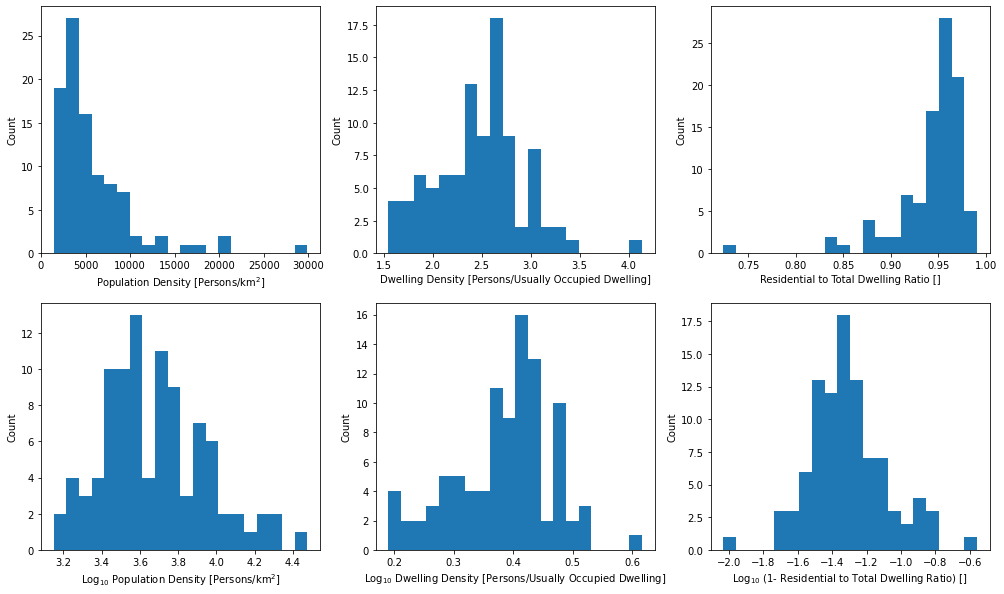

In [461]:
fig, axs = plt.subplots(2,3,figsize=(17,10))

ax = axs[0][0]
ax.hist(df_h['Population Density'],bins=20)
ax.set_xlabel('Population Density [Persons/km$^2$]')
ax.set_ylabel('Count')
ax = axs[1][0]
ax.hist(df_h['Population Density'].apply(np.log10),bins=20)
ax.set_xlabel('Log$_{10}$ Population Density [Persons/km$^2$]')
ax.set_ylabel('Count')

ax = axs[0][1]
ax.hist(df_h['Dwelling Density'],bins=20)
ax.set_xlabel('Dwelling Density [Persons/Usually Occupied Dwelling]')
ax.set_ylabel('Count')
ax = axs[1][1]
ax.hist(df_h['Dwelling Density'].apply(np.log10),bins=20)
ax.set_xlabel('Log$_{10}$ Dwelling Density [Persons/Usually Occupied Dwelling]')
ax.set_ylabel('Count')

ax = axs[0][2]
ax.hist(df_h['Residentiality'],bins=20)
ax.set_xlabel('Residential to Total Dwelling Ratio []')
ax.set_ylabel('Count')
ax = axs[1][2]
ax.hist((1-df_h['Residentiality']).apply(np.log10),bins=20)
ax.set_xlabel('Log$_{10}$ (1- Residential to Total Dwelling Ratio) []')
ax.set_ylabel('Count')

So that our variables are near-normally distributed, we should keep log$_{10}$ Population Density, unmodified Dwelling Density, and log$_{10}$ of 1 - the Residential to Total Dwelling Ratio.  The ranges will be adjusted using scalers during the classification.  Interestingly, the Population Density shows some evidence of clustering (though with only single low bins between the peaks, this may just be an artifact.

Let's construct and keep those variables in the dataframe:

In [463]:
df_h['Log10 (Population Density)'] = df_h['Population Density'].apply(np.log10)
df_h['Log10 (1 - Residentiality)'] = (1-df_h['Residentiality']).apply(np.log10)
df_h.head(1)

,Postal Code,Borough,Neighbourhood,GString,Latitude,Longitude,Population,Total Dwellings,Occupied Dwellings,Square km,Population Density,Residentiality,Dwelling Density,Log10 (Population Density),Log10 (1 - Residentiality)
0,M3A,North York,Parkwoods,"M3A, Toronto, ON, Canada, Toronto, ON M3A, CAN",43.75245,-79.32991,34615,13847,13241,7.818049,4427.575256,0.956236,2.614229,3.646166,-1.358883


Let's also recompute the nearest neighbor distance and index, since the number of rows has been reduced since we last did that.

In [453]:
def getNN(lat,lon):
    # Returns the NN distance in meters and index of NN given input arrays of latitude and longitude as Pandas series
    assert len(lat)==len(lon)
    dist_matrix = []
    for i in range(len(lat)):
        # This implementation is slow by a factor of 2, look into distance matrix functions
        dist_matrix.append([distance.distance((lat[i],lon[i]),(lat[j],lon[j])).meters for j in range(len(lat))])
    nn_dist = pd.Series(data=[min([x for x in y if x > 0]) for y in dist_matrix],name='NN Distance [m]')
    nn_index = pd.Series(data=[np.argmin(np.array([(9999999 if x==0 else x) for x in d])) for d in dist_matrix],name='NN Index',dtype=int)
    return nn_dist, nn_index

In [466]:
df_h = pd.concat([df_h,*getNN(df_h['Latitude'],df_h['Longitude'])],axis=1)
df_h.head()

,Postal Code,Borough,Neighbourhood,GString,Latitude,Longitude,Population,Total Dwellings,Occupied Dwellings,Square km,Population Density,Residentiality,Dwelling Density,Log10 (Population Density),Log10 (1 - Residentiality),NN Distance [m],NN Index
0,M3A,North York,Parkwoods,"M3A, Toronto, ON, Canada, Toronto, ON M3A, CAN",43.75245,-79.32991,34615,13847,13241,7.818049,4427.575256,0.956236,2.614229,3.646166,-1.358883,2372.990767,68
1,M4A,North York,Victoria Village,"M4A, Toronto, ON, Canada, Toronto, ON M4A, CAN",43.73057,-79.31306,14443,6299,6170,4.723358,3057.782424,0.979521,2.340843,3.485407,-1.688682,2458.529673,68
2,M5A,Downtown Toronto,"Regent Park, Harbourfront","M5A, Toronto, ON, Canada, Toronto, ON M5A, CAN",43.65512,-79.36264,41078,24186,22333,4.297526,9558.522031,0.923385,1.839341,3.980391,-1.115689,1117.129701,14
3,M6A,North York,"Lawrence Manor, Lawrence Heights","M6A, Toronto, ON, Canada, Toronto, ON M6A, CAN",43.72327,-79.45042,21048,8751,8074,5.829964,3610.313875,0.922637,2.606886,3.557545,-1.111469,1831.552727,9
4,M9A,Etobicoke,"Islington Avenue, Humber Valley Village","M9A, Toronto, ON, Canada, Toronto, ON M9A, CAN",43.66263,-79.52831,35594,15730,15119,10.651703,3341.625250,0.961157,2.354256,3.523958,-1.410688,1737.986298,92


And the distribution of neighborhood distances is now:

Text(0.5, 1.0, 'Toronto Postal Code Nearest-Neighbor Distances')

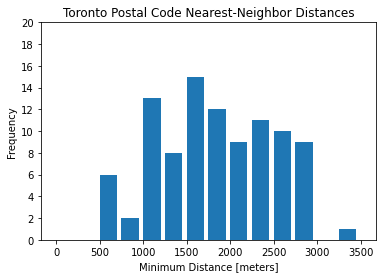

In [480]:
ax = df_h['NN Distance [m]'].plot(kind='hist', bins=np.arange(0,3750,250), width=200)
plt.yticks(np.arange(0,22,2));
plt.xlabel('Minimum Distance [meters]')
plt.title('Toronto Postal Code Nearest-Neighbor Distances')

So those close neighborhood distances had been due to zero-area postal codes.  Now neighborhoods are separated by at least 500 meters, which makes sense for a length scale for city characteristics to change between (a 5 minute walk).

Let's visualize our final dataframe for this section, sticking with the values from the HERE API lookup (in df_c), dropping the GString as it has served its purpose for validation, and keeping the nearest neighbor information as it might prove useful in the next section.

In [481]:
df_final = df_h.copy(deep=True)
df_final.drop(columns=['GString','Population','Total Dwellings','Occupied Dwellings','Square km','Population Density','Residentiality'],inplace=True)
df_final.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Dwelling Density,Log10 (Population Density),Log10 (1 - Residentiality),NN Distance [m],NN Index
0,M3A,North York,Parkwoods,43.75245,-79.32991,2.614229,3.646166,-1.358883,2372.990767,68
1,M4A,North York,Victoria Village,43.73057,-79.31306,2.340843,3.485407,-1.688682,2458.529673,68
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65512,-79.36264,1.839341,3.980391,-1.115689,1117.129701,14
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.72327,-79.45042,2.606886,3.557545,-1.111469,1831.552727,9
4,M9A,Etobicoke,"Islington Avenue, Humber Valley Village",43.66263,-79.52831,2.354256,3.523958,-1.410688,1737.986298,92


In [484]:
import folium

centroidlatlon = [df_final['Latitude'].mean(), df_final['Longitude'].mean()]

torontolatlon = gc.geocode("Toronto, Ontario")[1]
        
map_toronto = folium.Map(location=[centlat, centlon], zoom_start=11) # generate map centred around the center of postal codes

# add a red circle marker to represent the center of neighborhoods
folium.CircleMarker(
    centroidlatlon,
    radius=10,
    color='green',
    popup='Centroid of Toronto',
    tooltip='Centroid of Toronto',
    fill = True,
    fill_color = 'green',
    fill_opacity = 0.6
).add_to(map_toronto)

folium.CircleMarker(
    torontolatlon,
    radius=15,
    color='red',
    popup='Center of Toronto',
    tooltip='Center of Toronto',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(map_toronto)

for i, row in df_final[['Postal Code','Latitude','Longitude']].iterrows():
    folium.CircleMarker(
        [row['Latitude'], row['Longitude']],
        radius=5,
        color='blue',
        popup=row['Postal Code'],
        tooltip=row['Postal Code'],
        fill = True,
        fill_color = 'blue',
        fill_opacity = 0.6
    ).add_to(map_toronto)

map_toronto

Finally, let's view the final dataframe.

In [478]:
showalldf(df_final)

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Dwelling Density,Log10 (Population Density),Log10 (1 - Residentiality),NN Distance [m],NN Index
0,M3A,North York,Parkwoods,43.75245,-79.32991,2.614229,3.646166,-1.358883,2372.990767,68
1,M4A,North York,Victoria Village,43.73057,-79.31306,2.340843,3.485407,-1.688682,2458.529673,68
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65512,-79.36264,1.839341,3.980391,-1.115689,1117.129701,14
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.72327,-79.45042,2.606886,3.557545,-1.111469,1831.552727,9
4,M9A,Etobicoke,"Islington Avenue, Humber Valley Village",43.66263,-79.52831,2.354256,3.523958,-1.410688,1737.986298,92
5,M1B,Scarborough,"Malvern, Rouge",43.81139,-79.19662,3.267820,3.246560,-1.459795,2997.040194,90
6,M3B,North York,Don Mills,43.74923,-79.36186,2.664267,3.343089,-1.432117,1737.641521,43
7,M4B,East York,"Parkview Hill, Woodbine Gardens",43.70718,-79.31192,2.451375,3.555357,-1.459922,1985.175568,13
8,M5B,Downtown Toronto,"Garden District, Ryerson",43.65739,-79.37804,1.811420,4.311036,-0.840490,574.257874,23
9,M6B,North York,Glencairn,43.70687,-79.44812,2.658650,3.707978,-1.245047,1831.552727,3


## K-Means Clustering

To cluster postal codes, we will:
* Query Foursquare to get a list of nearby venues
* Construct a venue vector for each postal code from the venue lists
* Perform clustering on the vectors

For an unknown optimal number of clusters, we'll need to have a metric to tell us how many clusters is optimal.  We will use the elbow method, looking at the mean distance to a centroid vs k to see the elbow in a continuously decreasing line.

TODO: complete script here
Modifications: Scaler giving different scales to each dimension... possibly iterative based on cluster std in each dimension

### Discover Nearby Venues

We begin by loading Foursquare credentials and defining variables necessary for our queries.

In [623]:
import config

import importlib
importlib.reload(config)

CLIENT_ID = config.FOURSQUARE_CLIENT_ID
CLIENT_SECRET = config.FOURSQUARE_CLIENT_SECRET
ACCESS_TOKEN = config.FOURSQUARE_ACCESS_TOKEN
VERSION = '20180604'
LIMIT = 100
RADIUS = 500

We now define some utility functions for data acquisition and plotting.

In [717]:
import requests

# Queries a location to find nearby venues, uses session variables CLIENT_ID, CLIENT_SECRET, VERSION, LIMIT
def FoursquareExplore(latitude, longitude, radius):
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(
        CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
    results = requests.get(url).json()
    if results['response']=={}:
        if results['meta']['errorDetail']=='Quota exceeded':
            print('Foursquare quota exceeded, please try again later')
        else:
            print('No results returned')
        print(results)
    items = results['response']['groups'][0]['items']
    if len(items)>0:
        dataframe = pd.json_normalize(items)
        filtered_columns = ['venue.name', 'venue.categories'] + [col for col in dataframe.columns if col.startswith('venue.location.')] + ['venue.id']
        dataframe_filtered = dataframe.loc[:, filtered_columns]
        dataframe_filtered.columns = [col.split('.')[-1] for col in dataframe_filtered.columns]
        return dataframe_filtered
    else:
        return None

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

def getNearbyVenues(df_in, radius=500, extend=True):
    venues_df = pd.DataFrame(columns=['Postal Code','Venue Name','Venue Latitude','Venue Longitude','Venue Category','Radius'])
    for i, row in df_in.iterrows():
        # Get the neaby venues
        rad = radius
        df = FoursquareExplore(row['Latitude'],row['Longitude'],rad)
        print(row['Postal Code'])
        print(row['Postal Code'], f"radius {rad}", f"entries {df.shape[0] if not df is None else 0}")
        if extend:
            while (df is None or df.shape[0]<LIMIT/2) and rad<=max(radius,row['NN Distance [m]']/2):
                rad = rad+radius/2
                df = FoursquareExplore(row['Latitude'],row['Longitude'],rad)
                print(row['Postal Code'], f"radius {rad}", f"entries {df.shape[0] if not df is None else 0}")
        # Shorten the dataframe
        if not df is None:
            df_add = pd.DataFrame([[row['Postal Code'],r['name'],r['lat'],r['lng'],get_category_type(r),rad] for _, r in df.iterrows()], columns=venues_df.columns)
            venues_df = venues_df.append(df_add,ignore_index=True)
    return(venues_df)

def resumableGetNearbyVenues(df_in,df_venues=None,radius=500,extend=True):
    # Can be called with partial results in df_venues, and will resume populating it until another quota error from Foursquare
    # df_venues is populated only after satisfying query conditions (may need multiple calls if extend=True)
    # Need to deal with indexing - .loc uses dataframe indexes which are not necessarily zero-based 1-increment
    # TODO: Change selection method to evaluate indices only when they are not found in df_venues, this could also handle change of order
    if df_venues is None or df_venues.shape[0]==0:
        df_venues = pd.DataFrame(columns=['Postal Code','Venue Name','Venue Latitude','Venue Longitude','Venue Category','Radius'])
        current_index = 0
    else:
        last_postal_code = df_venues['Postal Code'][df_venues.shape[0]-1]
        current_index = np.asarray(df_in['Postal Code']==last_postal_code).nonzero()[0][0]+1
        # TODO: handle case where a complete df_venues is provided, though this should not occur because isComplete is returned
    
    isComplete = current_index == (df_in.shape[0])
    for index in range(current_index,df_in.shape[0]):
        try:
            df_add = getNearbyVenues(df_in.iloc[[index],:],radius=radius,extend=extend)
            df_venues = df_venues.append(df_add, ignore_index=True)
            isComplete = index == (df_in.shape[0]-1)
        except KeyError:
            isComplete = False
            print('Error encountered in venue lookup')
            break

    return isComplete, df_venues

We can now get nearby venues for each postal code.  The Radius entry is the radius (in meters) that is required for the Foursquare API to return at least LIMIT/2 (50) venues.  Radius is increased in increments of half the input radius until LIMIT/2 venues are returned if the extend parameter is True.

In [720]:
isComplete, df_venues = resumableGetNearbyVenues(df_final, None, radius=RADIUS, extend=True)
print('Venue lookup completed successfully' if isComplete else 'Venue lookup interrupted')
display(df_venues.head())

M3A
M3A radius 500 entries 3
M3A radius 750.0 entries 4
M3A radius 1000.0 entries 24
M3A radius 1250.0 entries 25
M4A
M4A radius 500 entries 4
M4A radius 750.0 entries 9
M4A radius 1000.0 entries 15
M4A radius 1250.0 entries 35
M5A
M5A radius 500 entries 21
M5A radius 750.0 entries 87
M6A
M6A radius 500 entries 51
M9A
M9A radius 500 entries 8
M9A radius 750.0 entries 14
M9A radius 1000.0 entries 11
M1B
M1B radius 500 entries 1
M1B radius 750.0 entries 4
M1B radius 1000.0 entries 5
M1B radius 1250.0 entries 25
M1B radius 1500.0 entries 33
M3B
M3B radius 500 entries 4
M3B radius 750.0 entries 25
M3B radius 1000.0 entries 34
M4B
M4B radius 500 entries 15
M4B radius 750.0 entries 21
M4B radius 1000.0 entries 19
M5B
M5B radius 500 entries 100
M6B
M6B radius 500 entries 11
M6B radius 750.0 entries 22
M6B radius 1000.0 entries 30
M9B
M9B radius 500 entries 5
M9B radius 750.0 entries 10
M9B radius 1000.0 entries 17
M1C
M1C radius 500 entries 3
M1C radius 750.0 entries 5
M1C radius 1000.0 entri

,Postal Code,Venue Name,Venue Latitude,Venue Longitude,Venue Category,Radius
0,M3A,Allwyn's Bakery,43.759840,-79.324719,Caribbean Restaurant,1250
1,M3A,Donalda Golf & Country Club,43.752816,-79.342741,Golf Course,1250
2,M3A,Tim Hortons,43.760668,-79.326368,Café,1250
3,M3A,Brookbanks Park,43.751976,-79.332140,Park,1250
4,M3A,Bruno's valu-mart,43.746143,-79.324630,Grocery Store,1250


If the lookup fails due to quotas (or presumably timeout), the following cell can be run until it completes.

In [723]:
if not isComplete:
    isComplete, df_venues = resumableGetNearbyVenues(df_final, df_venues, radius=RADIUS, extend=True)
    print('Venue lookup completed successfully' if isComplete else 'Venue lookup interrupted')
    display(df_venues)
else:
    print('Venue lookup is already finished')

Venue lookup is already finished


Let's make sure we have some features for every location:

In [768]:
missing_postal_codes = list(np.setdiff1d(df_final['Postal Code'],df_venues['Postal Code']))
print(f"There are {len(missing_postal_codes)} postal codes with no venues: {missing_postal_codes}")
print(f"There are {len(df_venues['Venue Category'].unique())} unique categories among {df_venues.shape[0]} venues (ratio of 1 to {df_venues.shape[0]/len(df_venues['Venue Category'].unique()):.1f}).")

There are 0 postal codes with no venues: []
There are 342 unique categories among 4202 venues (ratio of 1 to 12.3).


Let's see the distribution of number of venues found in each postal code:

Text(0, 0.5, 'Count of postal codes')

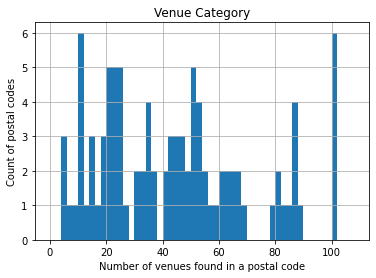

In [760]:
df_venue_counts = df_venues[['Postal Code','Venue Category']].groupby('Postal Code').count()
df_venue_counts.hist(bins=np.arange(0,110,2))
plt.xlabel('Number of venues found in a postal code')
plt.ylabel('Count of postal codes');

And the distribution of frequency of venue type across all of Toronto:

Text(0, 0.5, 'Count of venue categories')

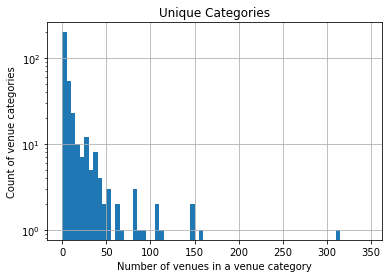

In [762]:
df_category_counts = df_venues[['Postal Code','Venue Category']].groupby('Venue Category').count()
df_category_counts.rename(columns={'Postal Code':'Unique Categories'},inplace=True)
df_category_counts.hist(bins=np.arange(0,350,5),log=True)
plt.xlabel('Number of venues in a venue category')
plt.ylabel('Count of venue categories');

Now it seems there is a [heirarchy of categories](https://developer.foursquare.com/docs/build-with-foursquare/categories/) and we might do well to restrict ourselves to higher level categories.  Let's get the category data structure:

In [868]:
print(len(x['response']['categories']))

10


In [870]:
try:
    categories_list = requests.get(f"https://api.foursquare.com/v2/venues/categories?&client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&v={VERSION}").json()
    categories_list = categories_list['response']['categories']
    print('Categories retrieved')
except KeyError:
    print('There was an error getting categories from Foursquare')

Categories retrieved


In [838]:
def findParentCategories(categories_list,categories_dict={},parents=[]):
    # Recursively explore categories_list, and modify categories_dict, where the keys are the categroies and values are lists of parents, highest first. 
    for c in categories_list:
        categories_dict[c['name']] = parents
        if len(c['categories'])==0: # Leaf condition
            categories_dict[c['name']] = parents
        else: # Branch condition
            findParentCategories(c['categories'],categories_dict,[*parents, c['name']])

def getCategoriesByDepth(categories_dict,depth=0):
    # Returns a dict of all categories at the given depth (with parent list for values)
    ret = {}
    for key, val in categories_dict.items():
        if len(val)==depth:
            ret[key] = val
    return ret

def getCategoryDepth(categories_dict,category):
    # Returns the integer dpeth of category in categories_dict
    return len(categories_dict['category'])

In [871]:
categories_dict = {}
findParentCategories(categories_list,categories_dict)
print(f"There are {len(categories_dict)} unique category labels.")

There are 970 unique category labels.


And we can examine how many labels are at each level of the hierarchy:

In [820]:
category_count = []
categories_depth_list = []
while sum(category_count)<len(categories_dict):
    categories_depth_list.append(getCategoriesByDepth(categories_dict,len(category_count)))
    category_count.append(len(categories_depth_list[-1]))
    print(f"There are {category_count[-1]} categories at depth {len(category_count)-1}.")

There are 10 categories at depth 0.
There are 470 categories at depth 1.
There are 382 categories at depth 2.
There are 94 categories at depth 3.
There are 14 categories at depth 4.


And we can examine how many labels are leaf or branch nodes:

In [874]:
leaf_list = []
node_list = []
for k in range(max(df_venues['Category Depth'])+1):
    leaf_list.append([])
    node_list.append([])

for key, val in categories_dict.items(): # Go through the dict; if a key appears in a value, it is a branch, if it never appears in a value (as a parent), it is a leaf
    node = False
    for k, v in categories_dict.items():
        if key==k:
            pass
        elif key in v: # Key appears as a parent
            node_list[len(val)].append(key)
            node=True
            break
    if not node: # Key did not appear as a parent - it is a leaf
        leaf_list[len(val)].append(key)

for k in range(len(leaf_list)):
    print(f"At depth {k} there are {len(node_list[k])} branches and {len(leaf_list[k])} leaves.")

At depth 0 there are 10 branches and 0 leaves.
At depth 1 there are 53 branches and 417 leaves.
At depth 2 there are 10 branches and 372 leaves.
At depth 3 there are 2 branches and 92 leaves.
At depth 4 there are 0 branches and 14 leaves.


We find out whether the Toronto venue categories occur at branch or leaf nodes:

In [879]:
leaf_toronto = [[] for k in range(len(leaf_list))]
node_toronto = [[] for k in range(len(node_list))]

for cat in df_venues['Venue Category']:
    for k in range(len(leaf_list)):
        if cat in leaf_list[k]:
            leaf_toronto[k].append(cat)
        if cat in node_list[k]:
            node_toronto[k].append(cat)

for k in range(len(leaf_toronto)):
    print(f"At depth {k} there are {len(node_toronto[k])} categories that are branches and {len(leaf_toronto[k])} categories that are leaves.")

At depth 0 there are 3 categories that are branches and 0 categories that are leaves.
At depth 1 there are 655 categories that are branches and 2478 categories that are leaves.
At depth 2 there are 229 categories that are branches and 678 categories that are leaves.
At depth 3 there are 1 categories that are branches and 157 categories that are leaves.
At depth 4 there are 0 categories that are branches and 1 categories that are leaves.


An alternative earlier approach found the sum of branch and leaf categories:

In [857]:
df_venues['Category Parents'] = [categories_dict[row['Venue Category']] for _, row in df_venues.iterrows()]
df_venues['Category Depth'] = df_venues['Category Parents'].apply(len)
display(df_venues.head(3))

for k in np.sort(df_venues['Category Depth'].unique()):
    colname = f"Venue Category, Depth {k}"
    print(f"At depth {k} there are {sum(df_venues['Category Depth']==k)} venue category entries.")

,Postal Code,Venue Name,Venue Latitude,Venue Longitude,Venue Category,Radius,Category Depth,Category Parents,"Venue Category, Depth 0","Venue Category, Depth 1","Venue Category, Depth 2","Venue Category, Depth 3","Venue Category, Depth 4"
0,M3A,Allwyn's Bakery,43.759840,-79.324719,Caribbean Restaurant,1250,1,[Food],Food,Caribbean Restaurant,Caribbean Restaurant,Caribbean Restaurant,Caribbean Restaurant
1,M3A,Donalda Golf & Country Club,43.752816,-79.342741,Golf Course,1250,2,"[Outdoors & Recreation, Athletics & Sports]",Outdoors & Recreation,Athletics & Sports,Golf Course,Golf Course,Golf Course
2,M3A,Tim Hortons,43.760668,-79.326368,Café,1250,1,[Food],Food,Café,Café,Café,Café


At depth 0 there are 3 venue category entries.
At depth 1 there are 3133 venue category entries.
At depth 2 there are 907 venue category entries.
At depth 3 there are 158 venue category entries.
At depth 4 there are 1 venue category entries.


This doesn't look too unreasonable... it would make sense to create one-hots both for leaf and node categories and to assign more weight in the clustering to lower depth nodes (to emphasize matching broader categories first, but this may get needlessly complex.  We can generate the additional one-hot dataframes just in case, but then continue with the simpler analysis first.

In [853]:
for k in np.sort(df_venues['Category Depth'].unique()):
    df_venues[[f"Venue Category, Depth {k}"]] = [row['Venue Category'] if row['Category Depth']<=k else row['Category Parents'][k] for _,row in df_venues.iterrows()]
df_venues.head()

,Postal Code,Venue Name,Venue Latitude,Venue Longitude,Venue Category,Radius,Category Depth,Category Parents,"Venue Category, Depth 0","Venue Category, Depth 1","Venue Category, Depth 2","Venue Category, Depth 3","Venue Category, Depth 4"
0,M3A,Allwyn's Bakery,43.759840,-79.324719,Caribbean Restaurant,1250,1,[Food],Food,Caribbean Restaurant,Caribbean Restaurant,Caribbean Restaurant,Caribbean Restaurant
1,M3A,Donalda Golf & Country Club,43.752816,-79.342741,Golf Course,1250,2,"[Outdoors & Recreation, Athletics & Sports]",Outdoors & Recreation,Athletics & Sports,Golf Course,Golf Course,Golf Course
2,M3A,Tim Hortons,43.760668,-79.326368,Café,1250,1,[Food],Food,Café,Café,Café,Café
3,M3A,Brookbanks Park,43.751976,-79.332140,Park,1250,1,[Outdoors & Recreation],Outdoors & Recreation,Park,Park,Park,Park
4,M3A,Bruno's valu-mart,43.746143,-79.324630,Grocery Store,1250,2,"[Shop & Service, Food & Drink Shop]",Shop & Service,Food & Drink Shop,Grocery Store,Grocery Store,Grocery Store


In [855]:
for k in np.sort(df_venues['Category Depth'].unique()):
    colname = f"Venue Category, Depth {k}"
    print(f"There are {len(df_venues[colname].unique())} unique categories limited to depth {k}")

There are 9 unique categories limited to depth 0
There are 231 unique categories limited to depth 1
There are 322 unique categories limited to depth 2
There are 342 unique categories limited to depth 3
There are 342 unique categories limited to depth 4


From this we expect that most the optimal category depth will be 1 or 2; depth 0 is too general, while depth above 2 becomes too specific and adds little additional information (no information in the case of depth 4).

Note that the columns 'Venue Category' and 'Venue Category, Depth 4' are equivalent.

In [858]:
all(df_venues['Venue Category']==df_venues['Venue Category, Depth 4'])

True

#### Create a venue vector for each neighborhood

In [893]:
def makeOneHot(df,colname,keycolname):
    # Returns (onehot of df[colname] with first column df[keycolname],
    #          stuff)
    onehot = pd.get_dummies(df[[colname]], prefix="", prefix_sep="")
    onehot[keycolname] = df[keycolname]
    onehot = onehot[[onehot.columns[-1]] + list(onehot.columns[:-1])]
    grouped = onehot.groupby(keycolname).mean().reset_index()
    return onehot, grouped

In [894]:
# Basic one-hot encoding
toronto_onehot, toronto_grouped = makeOneHot(df_venues,'Venue Category','Postal Code')

# Create columns to hold venues limited to a given depth
toronto_onehot_0, toronto_grouped_0 = makeOneHot(df_venues,'Venue Category, Depth 0','Postal Code')
toronto_onehot_1, toronto_grouped_1 = makeOneHot(df_venues,'Venue Category, Depth 1','Postal Code')
toronto_onehot_2, toronto_grouped_2 = makeOneHot(df_venues,'Venue Category, Depth 2','Postal Code')
toronto_onehot_3, toronto_grouped_3 = makeOneHot(df_venues,'Venue Category, Depth 3','Postal Code')
toronto_onehot_4, toronto_grouped_4 = makeOneHot(df_venues,'Venue Category, Depth 4','Postal Code')

display(toronto_onehot.head())
print(f"Shape: {toronto_onehot.shape}")

,Postal Code,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Animal Shelter,Antique Shop,Aquarium,...,Video Store,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit
0,M3A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,M3A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,M3A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,M3A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,M3A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Shape: (4202, 343)


In [895]:
display(toronto_grouped.head())
print(f"Shape: {toronto_grouped.shape}")

,Postal Code,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Animal Shelter,Antique Shop,Aquarium,...,Video Store,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit
0,M1B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.393939
1,M1C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,M1E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,M1G,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.055556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,M1H,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


Shape: (96, 343)


In [912]:
def printNeighborhoodVenueFrequency(df_tmp, key_col_name='Postal Code', num_top_venues=5):
    for hood in df_tmp[key_col_name]:
        neighborhoods_str = ''
        for n in df_final.loc[df_final['Postal Code']==hood,'Neighbourhood']:
            neighborhoods_str += n
        print("----"+hood+": "+neighborhoods_str+"----")
        temp = df_tmp[df_tmp[key_col_name] == hood].T.reset_index()
        temp.columns = ['venue','freq']
        temp = temp.iloc[1:]
        temp['freq'] = temp['freq'].astype(float)
        temp = temp.round({'freq': 2})
        print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
        print('\n')

In [913]:
printNeighborhoodVenueFrequency(toronto_grouped,'Postal Code',5)

----M1B: Malvern, Rouge----
                  venue  freq
0           Zoo Exhibit  0.39
1  Fast Food Restaurant  0.06
2           Coffee Shop  0.06
3                 Trail  0.06
4            Hobby Shop  0.03


----M1C: Rouge Hill, Port Union, Highland Creek----
            venue  freq
0            Park  0.21
1            Bank  0.07
2     Pizza Place  0.07
3    Neighborhood  0.07
4  Breakfast Spot  0.07


----M1E: Guildwood, Morningside, West Hill----
            venue  freq
0     Pizza Place  0.09
1  Breakfast Spot  0.07
2            Park  0.07
3      Restaurant  0.07
4            Bank  0.04


----M1G: Woburn----
                  venue  freq
0                  Park  0.11
1     Indian Restaurant  0.11
2           Pizza Place  0.11
3  Fast Food Restaurant  0.11
4             Juice Bar  0.06


----M1H: Cedarbrae----
               venue  freq
0  Indian Restaurant  0.17
1        Coffee Shop  0.09
2    Supplement Shop  0.04
3    Thai Restaurant  0.04
4        Flower Shop  0.04


----M1J: S

In [914]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [916]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Postal Code']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Postal Code'] = toronto_grouped['Postal Code']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Postal Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Zoo Exhibit,Coffee Shop,Trail,Fast Food Restaurant,Supermarket,Bank,Gas Station,Caribbean Restaurant,Grocery Store,Gym
1,M1C,Park,Burger Joint,Gym / Fitness Center,Gym,Italian Restaurant,Pharmacy,Pizza Place,Neighborhood,Breakfast Spot,Bank
2,M1E,Pizza Place,Park,Restaurant,Breakfast Spot,Bank,Hotel,Coffee Shop,Fast Food Restaurant,Medical Center,Bar
3,M1G,Park,Pizza Place,Fast Food Restaurant,Indian Restaurant,Thrift / Vintage Store,Supermarket,Sandwich Place,Juice Bar,Coffee Shop,Supplement Shop
4,M1H,Indian Restaurant,Coffee Shop,Fried Chicken Joint,Hakka Restaurant,Burger Joint,Flower Shop,Music Store,Caribbean Restaurant,Supplement Shop,Gas Station


Here, set up testing of clustering

### Session Import

If resuming from an old session, load precomputed variables by converting to code and running the following block:
    
    import dill
    dill.load_session('notebook_env.db')
    
(note: the above block won't work in Jupyterlab with its hooks; as a workaround load the time-intensive RESULTS variable and regenerate everything else manually)

    # CAREFUL! This will load previously picled RESULTS into the environment.
    # All other variables will have to be regenerated.
    # Ease of regeneration has not yet been tested.
    import dill
    with open('loan_evaluation_results.db','rb') as file:
        RESULTS = dill.load(file)

In [ ]:
import dill
with open('toronto_df_final.db','rb') as file:
    df_final = dill.load(file)
with open('toronto_df_venues.db','rb') as file:
    df_venues = dill.load(file)

### Session Export

Convert to code and run the following block to save the environment:

    dill.dump_session(filename)

(note that some objects cannot be pickled, like dict_keys and other generators, so make sure they are removed first)

(apparently Jupyterlab hooks prevent pickling, so we can choose to pickle just RESULTS to speed up reruns)

In [920]:
import dill
with open('toronto_df_final.db','wb') as file:
    dill.dump(df_final,file)
with open('toronto_df_venues.db','wb') as file:
    dill.dump(df_venues,file)

In [918]:
from sklearn.cluster import KMeans
df_features = toronto_grouped.drop('Postal Code', 1)
#df_features = df_final[['Density','...']].concat(toronto_grouped.drop('Postal Code', 1))
# set number of clusters
ks = range(1,11)
mss = [] # Mean sum of squares of intracluster distances to cluster centroid
for i, k in enumerate(ks):
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=12, n_jobs=6).fit(df_features)
    mss[i] = kmeans.inertia_
    print(f"{k} clusters mss = {mss[i]}")
plt.plot(ks,mss)

ModuleNotFoundError: No module named 'sklearn'

Here set model for optimal cluster number

Here evaluate dominant predictors

In [ ]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

manhattan_merged = manhattan_data

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
manhattan_merged = manhattan_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

manhattan_merged.head() # check the last columns!

In [ ]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [ ]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 0, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

DO ANOVA to figure out which variables are the best predictors of class... maybe not the best with a lot of one-hot encoding


#### keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]



# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

Explore and cluster the neighborhoods in Toronto. You can decide to work with only boroughs that contain the word Toronto and then replicate the same analysis we did to the New York City data. It is up to you.

Just make sure:

    to add enough Markdown cells to explain what you decided to do and to report any observations you make.
    to generate maps to visualize your neighborhoods and how they cluster together. 

Once you are happy with your analysis, submit a link to the new Notebook on your Github repository. (3 marks)

## APPENDIX

### Foray into BeautifulSoup for parsing webpages: obsolete because pandas.read_html() works fine.

Next we will parse the webpage using [Beautiful Soup]('https://beautiful-soup-4.readthedocs.io/en/latest/').

from bs4 import BeautifulSoup # had to install to environment in Anaconda

soup = BeautifulSoup(webpage.text, 'html.parser')

To view the HTML directly we could run:

    print(soup.prettify())
    
But we can also inspect the webpage for the table we expect:

tables = soup.find_all('table')
len(tables)

for i, table in enumerate(tables):
    print('Length of table {} string: {}, attributes: {}'.format(i,len(table.text),table.attrs))

import lxml
import html5lib

str(tables[0])

df_pcodes = pd.read_html(str(tables[0]))[0]
#df_pcodes = pd.DataFrame(df_pcodes[1:][:],df_pcodes[1:][1],df_pcodes[0][:])
type(df_pcodes)
df_pcodes

### Installation of dependencies: with relation to developing in Anaconda

    conda install -c conda-forge geocoder

Gave problem with openssl-1.1.1h-he774522_0.tar.bz2

From Anaconda Navigator, I removed openssl, restarted, then installed it again.

Doing so seemed to reset the environment; I had to reinstall jupyterlab, pandas, numpy, lxml, html5lib, bs4.

I also discovered the Channels setting, and by adding conda-forge I was able to access packages that I installed through the prompt before:
geocoder, jupyterlab-git, ipywidgets.

So there may be additional fallout from this, but at least I can use Aanconda as intended now that I can get the packages I need through the UI.

### Geocoding

Unfortunately, geocoder.google('Ottawa, ON') and other services from geocoder failed to return data (over 200 explicit calls and over 20 minutes in a loop in the case of google, except for CanadaPost which did work, but that only returns a postal code).  Instead I elect to use Nominatim, we'll see if that works for Toronto...

The following cells are the original geocoding work:

I would like to try to get latitude and longitude for each neighborhood, so let's make a new dataframe:

    df_n = pd.DataFrame(columns=df_cleaned.columns) 
    for i, row in df_cleaned.iterrows():
        for neighborhood in row['Neighbourhood'].split(', '):
            df_n = df_n.append(row, ignore_index=True)
            df_n.loc[df_n.shape[0]-1,'Neighbourhood'] = neighborhood
    df_n.head(10)

    When a neighborhood appears in several postal codes, part of the neighborhood appears in each one.  In absence of geographic boundary polygons, let's weight the location of each neighborhood by the inverse of its number of appearances overall when we average the latitude and longitude of neighborhoods to get the postal code locations.  So let's count the number of times the neighborhood appears in the list.

    for i, row in df_n.iterrows():
        df_n.loc[i, 'Count'] = int(df_n[df_n['Neighbourhood']==row['Neighbourhood']].shape[0])
    df_n['Count'] = pd.to_numeric(df_n['Count'], downcast='integer')

    display(df_n.head())
    df_n[['Count']].value_counts(sort=False)

    Good, not many neighborhoods appear in more than one postal code, so this should not have much effect on the results.

    Next we will geocode the neighborhoods.

    Attempting to geocode a latitude and longitude in a non-commercial environment requires some effort.

    Going through some of the list at the geocoder [documentation](https://geocoder.readthedocs.io/):
    * geopy.geocoders.google never returned a location in over 200 calls
    * geopy.geocoders.canadapost does note return latitude and longitude
    * geopy.geocoders.geolytica throws AttributeError: 'dict' object has no attribute 'strip' (see alternate geocoder.ca approach below)
    * geopy.geocoders.bing requires an API key
    * geopy.geocoders.tomtom requires an API key
    * geopy.geocoders.mapquest requires an API key
    * geopy.geocoders.mapbox requires an API key
    * geopy.geocoders.yahoo returns a KeyError: 'statusDescription'
    * geopy.geocoders.ottawa does not return many responses
    * geopy.geocoders.Nominatim (osm) gives a reasonable number of responses, will go with this

    Another option is to go though website requests directly, e.g.

        https://geocoder.ca/T0H 2N2?json=1

    This returns a JSON with latitude and longitude for a postal code.  However, this requires a full code and is limited to 500-2000 requests per day.  An exhaustive search of final three digits of postal code and averaging the locations of the returns would require ~2600 requests per entry, which is prohibitive.

    from geopy.geocoders import Nominatim
    from geopy.extra.rate_limiter import RateLimiter

    import config

    geolocator = Nominatim(user_agent=config.NM_AGENT)
    geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1.5) # Hard minimum is 1.0 seconds

    df_n['GString'] = None
    df_n['Lat'] = None
    df_n['Lon'] = None
    df_n.head()

    for i, row in df_n.iterrows():
        g = geocode(f"{row['Neighbourhood']}, Toronto, Ontario")
        if g!=None:
            df_n.loc[i, 'GString'] = g[0]
            df_n.loc[i, 'Lat'] = g[1][0]
            df_n.loc[i, 'Lon'] = g[1][1]
    df_n.head()

    Let's find the indices where the lookup failed:

    ind_fail = df_n.index[~df_n['GString'].notnull()]
    print(f'Lookup failed for {len(ind_fail)} neighbourhoods')

    Construct a dataframe of these missing values for refilling:

    df_nfail = df_n.loc[ind_fail,:]
    showalldf(df_nfail)

    Let's try filling in these blanks by adjusting the search string:

    for i, row in df_nfail.iterrows():
        g = geocode(f"{row['Neighbourhood']}, {row['Borough']}, Ontario")
        if g!=None:
            df_nfail.loc[i, 'GString'] = g[0]
            df_nfail.loc[i, 'Lat'] = g[1][0]
            df_nfail.loc[i, 'Lon'] = g[1][1]
    showalldf(df_nfail)

    Not so easy, let's try adding the postal code:

    geocode(f"Capitol Building, Toronto, Ontario")

    geocode('Caledonia, Toronto, Ontario')

    geocode('Fairbank, Toronto, Ontario')

    geocode('Caledonia-Fairbank, Toronto, Ontario')

    geocode('Del Rey, Toronto, Ontario')

    geocode('Keelesdale, Toronto, Ontario')

    geocode('Silverthorn, Toronto, Ontario')

    geocode('Keelesdale and Silverthorn, Toronto, Ontario')

    geocode('union station, Toronto, Ontario')

    geocode('local airport, Toronto, Ontario')

    geocode('humber bay, Toronto, Ontario')

    geocode('beaumonde heights, Toronto, Ontario')

    So some locations can be found; names are spelled slightly differently, and some are not correct.

    Going through Google Maps there is functionality for obtaining boudaries of postal codes, and I used this to check the above, but I don't particularly want to pay for that.



    Let's also find where the returned location string does not match the neighborhood name exactly, and make a new dataframe for those entries as well.

    showalldf(df_n)

    ind_mismatch = []
    for i, row in df_n.iterrows():
        if row['GString']!=None and row['GString'].split(',')[0]!=row['Neighbourhood']:
            ind_mismatch.append(i)
    ind_mismatch = df_n.index[ind_mismatch]
    print(f'Non-exact lookups for {len(ind_mismatch)} neighbourhoods')

    df_nmismatch = df_n.loc[ind_mismatch,:]
    df_nmismatch.head()



    for i, row in df_n.iterrows():
        if row['GString']!=None:
            df_n.loc[i,'Found?'] = row['GString'].split(',')[0]==row['Neighbourhood']
    df_n.head(100)

    df_n.loc[df_n['Found?']==False,'Found?'].count()

    for _, row in df_n.iterrows():
        print(f"{row['Neighbourhood']}, Toronto, Ontario")

    ll = []
    for b in df['Borough'].unique():
        ll.append(geocode(f'{b}, ON, Canada'))
    ll

    df['Borough'].unique()

    llpc = [geocode(f'{pc}, ON, Canada') for pc in df['Postal Code']]
    llpc

    This didn't turn out so well.  Let's try with neighborhood names.

    df['Neighbourhood'][2].split(',')

    df.rows()

    llnt = [geocode(f"{n}, {r['Borough']}, Ontario, Canada") for _, r in df.iterrows() for n in r['Neighbourhood'].split(',')]

    llnt

    llnt2 = [None if r['Borough']!='Downtown Toronto' else geocode(f"{n}, {r['Borough'].split()[-1]}, Ontario, Canada") for _, r in df.iterrows() for n in r['Neighbourhood'].split(',')]
    llnt2

    For below, 'Downtown Toronto' fails, maybe just put Toronto, or omit the Borough

    # Combine llnt and llnt2
    llnt3 = [tt if t==None else t for t, tt in zip(llnt, llnt2)]
    llnt3

    # Get the indices of the None entries for further inspection
    llnt3list = [i for i, x in enumerate(llnt3) if x==None]
    print(f'Number of missing entries: {len(llnt3list)}')
    print(f'At indices: {llnt3list}')

    Let's try again, as other modifiers of Toronto in the Borough name may be confusing

    llnt4 = [None if r['Borough'].split()[-1]!='Toronto' else geocode(f"{n}, {r['Borough'].split()[-1]}, Ontario, Canada") for _, r in df.iterrows() for n in r['Neighbourhood'].split(',')]
    llnt4

    # Combine results
    llnt5 = [tt if t==None else t for t, tt in zip(llnt3, llnt4)]
    llnt5

    # Get the indices of the None entries for further inspection
    llnt5list = [i for i, x in enumerate(llnt5) if x==None]
    print(f'Number of missing entries: {len(llnt5list)}')
    print(f'At indices: {llnt5list}')

    So two more entries were found, better than nothing.

    Let's work at combining entries to make a lat/long for each postal code



    lllist = [x[1] for x in llnt5 if x!=None]
    a, b = zip(*lllist)
    print(min(a), max(a), np.std(a), min(b), max(b), np.std(b))

    [(f"{n}, {r['Borough']}, Ontario, Canada") for _, r in df.iterrows() for n in r['Neighbourhood'].split(',')]

    lln = [geocode(f'{n}, ON, Canada') for n in [s.split(',', trim=True) for s in df['Neighbourhood']]]
    lln

    df['location'] = df['name'].apply(geocode)
    df.head()

    address = 'The Kingsway, Toronto, ON'
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    location

    address = 'Old Mill North, Toronto, ON'
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    location

    address = 'Montgomery Road, Toronto, ON'
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    location

    import geocoder
    # initialize your variable to None
    lat_lng_coords = None

    postal_code = 'M3A'

    # loop until you get the coordinates
    while(lat_lng_coords is None):
      g = geocoder.google('{}, Toronto, Ontario'.format(postal_code))
      lat_lng_coords = g.latlng

#### Testing Foursquare Lookup

    #df_in_test = df_final.iloc[0:2,:]
    #df_venues_test = None
    df_in_test = df_final.iloc[0:6,:]
    isComplete_test, df_venues_test = resumableGetNearbyVenues(df_in_test, df_venues_test, radius=RADIUS, extend=True)
    print('Venue lookup completed successfully' if isComplete_test else 'Venue lookup interrupted')